In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
batch_size = 128
learning_rate = 0.005
num_epoch = 10
hidden_size = 50

In [3]:
mnist_train = dset.MNIST('./', train=True, transform=transforms.ToTensor())
mnist_test = dset.MNIST('./', train=False, transform=transforms.ToTensor())

In [4]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, 
                          shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size,
                         shuffle=False, num_workers=2, drop_last=True)

In [28]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1_1 = nn.Linear(784, hidden_size)
        self.fc1_2 = nn.Linear(784, hidden_size)
        self.relu = nn.ReLU()
        
    def encode(self, x):
        x = x.view(batch_size, -1)
        mu = self.relu(self.fc1_1(x))
        log_var = self.relu(self.fc1_2(x))
        
        return mu, log_var
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        
        eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        
        return eps.mul(std).add_(mu)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        reparam = self.reparametrize(mu, logvar)
        
        return mu, logvar, reparam

encoder = Encoder()

In [32]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(hidden_size, 784)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = out.view(batch_size, 28, 28, 1)
        
        return out

decoder = Decoder()

In [33]:
reconstruction_function = nn.BCELoss(size_average=False)

def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)
    
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    
    return BCE + KLD

parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [34]:
try:
    encoder, decoder = torch.load('variational_autoencoder.pkl')
    print('\n--------model restored--------\n')
except:
    print('\n--------model not restored--------\n')
    pass

for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        optimizer.zero_grad()
        
        image = Variable(image)
        mu, log_var, reparam = encoder(image)
        output = decoder(reparam)
        
        loss = loss_function(output, image, mu, log_var)
        
        loss.backward()
        optimizer.step()
        
        if j % 100 == 0:
            torch.save([encoder, decoder], 'variational_autoencoder.pkl')
            print(loss)


--------model not restored--------

tensor(74455.7969, grad_fn=<AddBackward0>)


/home/p829911/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([128, 1, 28, 28])) that is different to the input size (torch.Size([128, 28, 28, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/p829911/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/p829911/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/p829911/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for co

tensor(25962.0430, grad_fn=<AddBackward0>)
tensor(22757.0723, grad_fn=<AddBackward0>)
tensor(22920.8125, grad_fn=<AddBackward0>)
tensor(22534.5977, grad_fn=<AddBackward0>)
tensor(22011.5918, grad_fn=<AddBackward0>)
tensor(22335.6738, grad_fn=<AddBackward0>)
tensor(21652.3184, grad_fn=<AddBackward0>)
tensor(22096.7969, grad_fn=<AddBackward0>)
tensor(21336.7129, grad_fn=<AddBackward0>)
tensor(22225.2910, grad_fn=<AddBackward0>)
tensor(22037.6445, grad_fn=<AddBackward0>)
tensor(21757.8477, grad_fn=<AddBackward0>)
tensor(21357., grad_fn=<AddBackward0>)
tensor(21637.6328, grad_fn=<AddBackward0>)
tensor(21982.0977, grad_fn=<AddBackward0>)
tensor(21572.5469, grad_fn=<AddBackward0>)
tensor(22032.5625, grad_fn=<AddBackward0>)
tensor(21876.5020, grad_fn=<AddBackward0>)
tensor(21645.1172, grad_fn=<AddBackward0>)
tensor(21317.7754, grad_fn=<AddBackward0>)
tensor(21640.8340, grad_fn=<AddBackward0>)
tensor(21616.9160, grad_fn=<AddBackward0>)
tensor(21531.6738, grad_fn=<AddBackward0>)
tensor(21274.03

torch.Size([128, 28, 28])


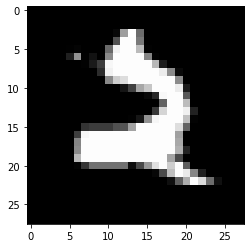

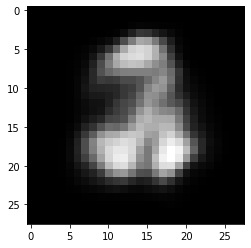

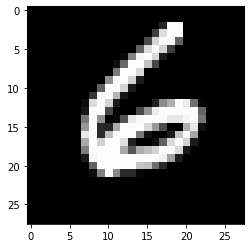

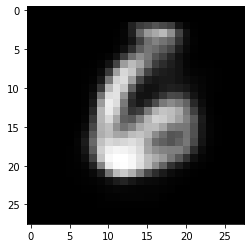

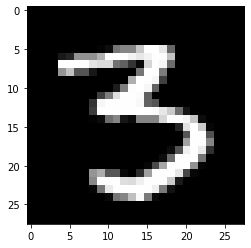

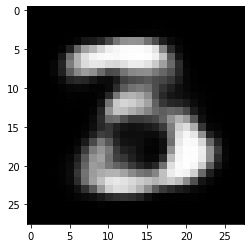

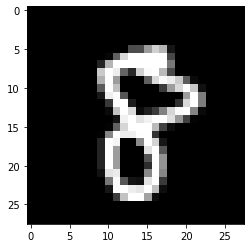

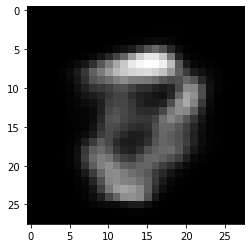

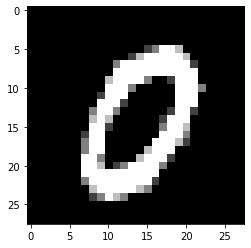

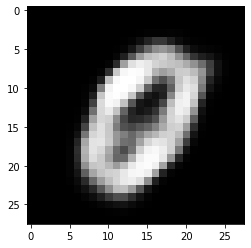

In [40]:
out_img = torch.squeeze(output.data)
print(out_img.size())
for i in range(5):
    plt.imshow(torch.squeeze(image[i]).numpy(), cmap='gray')
    plt.show()
    plt.imshow(out_img[i].numpy(), cmap='gray')
    plt.show()

In [42]:
for i in range(1):
    for j, [image, label] in enumerate(test_loader):
        
        image = Variable(image, volatile=True)
        mean, var, output = encoder(image)
        output = decoder(output)
        loss = loss_function(output, image, mean, var)
        
        if j % 10 == 0:
            print(loss)

/home/p829911/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


tensor(20683.1348, grad_fn=<AddBackward0>)
tensor(20677.5488, grad_fn=<AddBackward0>)
tensor(20770.7246, grad_fn=<AddBackward0>)
tensor(21553.0605, grad_fn=<AddBackward0>)
tensor(21026.4609, grad_fn=<AddBackward0>)
tensor(20992.1465, grad_fn=<AddBackward0>)
tensor(21733.7070, grad_fn=<AddBackward0>)
tensor(23035.5664, grad_fn=<AddBackward0>)


torch.Size([128, 28, 28])


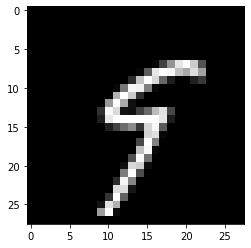

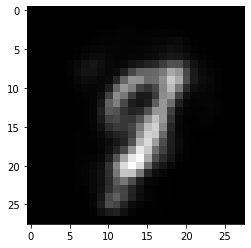

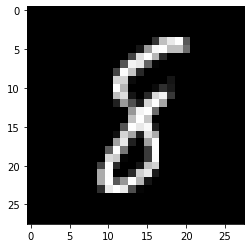

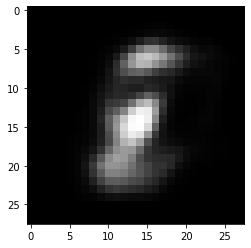

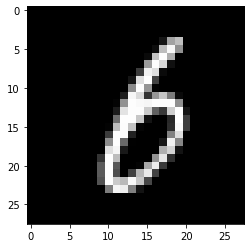

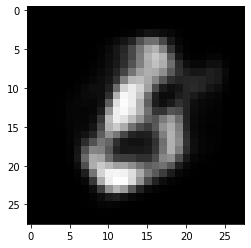

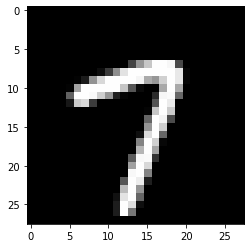

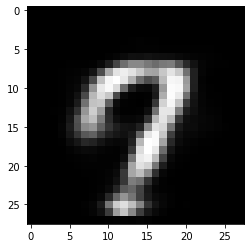

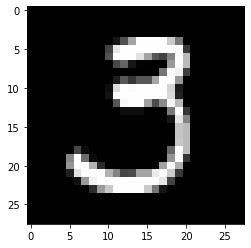

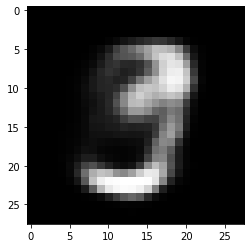

In [47]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.imshow(torch.squeeze(image[i].cpu()).data.numpy(),cmap='gray')
    plt.show()
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()